## RNNs Introduction

In this notebook, we will create different examples with RNNs to predict the following $k$ values in a time series. We will review simple RNNs to estimate the next value and then calculate the following $k$ values using Deep RNNs. Finally, we will review the LSTM networks that tackle the problem of short-term memory of RNNs.  

### Setup

First, we will import libraries and define constants and functions that will help us during the examples in this notebook.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os
from pathlib import Path

# to make this notebook's output stable across runs
my_seed = 42
np.random.seed(my_seed)
tf.random.set_seed(my_seed)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

No GPU was detected. LSTMs and CNNs can be very slow without a GPU.


The following cell defines a function that allows us to save images.

In [2]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

During this notebook, we will work with time series; the following function created randomized time series. The use case can vary, for example, stock prices, movie ratings, etc.

In [3]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

The `plot_series` function displays a time series and its label, which is the last data point and the one that we want to predict.

In [4]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "rx", markersize=10, label="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")

### Estimating the Next Value

Through the next examples, we will implement different ways of predicting the next value in a time series using RNNs, but first, we need to define the training, validation and test sets. We will generate different time series, with multiple time steps.

The last value of the time series will be the target variable, since we want to predict the next value.

In [5]:
np.random.seed(my_seed)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [6]:
print(X_train.shape)
print(y_train.shape)

(7000, 50, 1)
(7000, 1)


Let's plot the fist three time series to have a better idea of our data. The big blue dot represents the target variable.

Saving figure time_series_plot


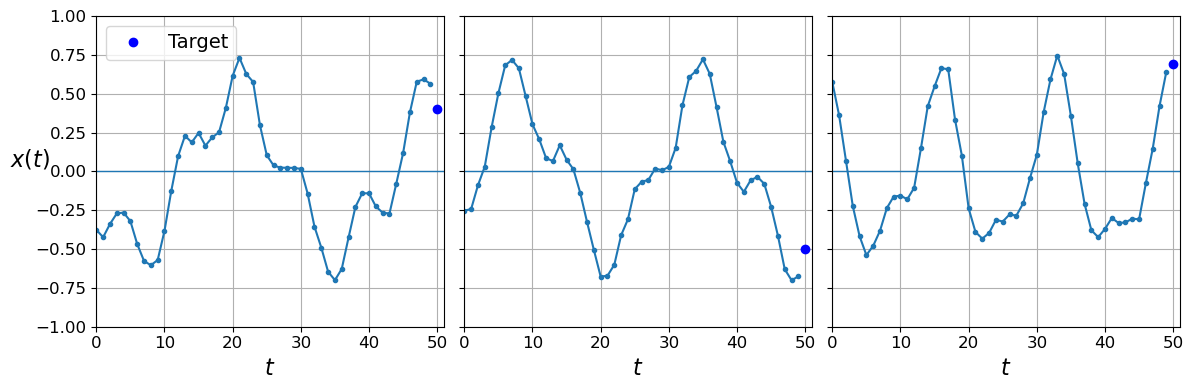

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None),
                legend=(col == 0))
save_fig("time_series_plot")
plt.show()

#### Linear Model

Before using RNNs, let's see how a simple linear model performs with our data. Let's create a sequential model, with just a dense layer with a single neuron that represents the output. **This is a regression problem, so we don't specify an activation function**.

In [8]:
np.random.seed(my_seed)
tf.random.set_seed(my_seed)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
  1/219 [..............................] - ETA: 35s - loss: 0.3696

2023-05-11 13:11:56.009944: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


219/219 [==============================] - 0s 686us/step - loss: 0.1341 - val_loss: 0.0563
Epoch 2/20
219/219 [==============================] - 0s 419us/step - loss: 0.0364 - val_loss: 0.0247
Epoch 3/20
219/219 [==============================] - 0s 426us/step - loss: 0.0187 - val_loss: 0.0153
Epoch 4/20
219/219 [==============================] - 0s 413us/step - loss: 0.0128 - val_loss: 0.0118
Epoch 5/20
219/219 [==============================] - 0s 413us/step - loss: 0.0103 - val_loss: 0.0101
Epoch 6/20
219/219 [==============================] - 0s 413us/step - loss: 0.0090 - val_loss: 0.0089
Epoch 7/20
219/219 [==============================] - 0s 413us/step - loss: 0.0081 - val_loss: 0.0081
Epoch 8/20
219/219 [==============================] - 0s 412us/step - loss: 0.0073 - val_loss: 0.0073
Epoch 9/20
219/219 [==============================] - 0s 414us/step - loss: 0.0067 - val_loss: 0.0067
Epoch 10/20
219/219 [==============================] - 0s 407us/step - loss: 0.0061 - val_los

In [9]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 306us/step - loss: 0.0040


0.004009051248431206

We get a validation error of around 0.004, let's visualize the predicted next value for the first time series in our validation set.

63/63 [==============================] - 0s 263us/step


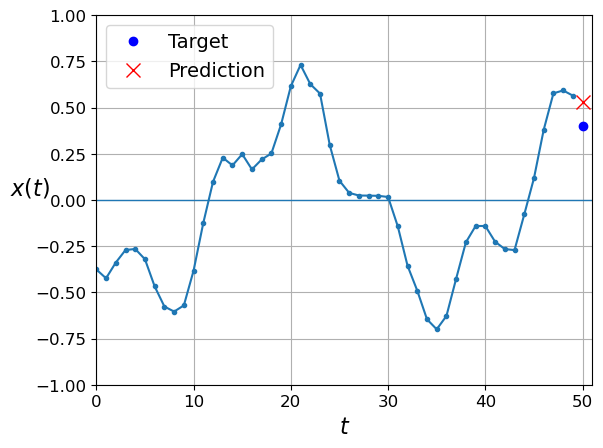

In [10]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

#### Using RNNs 

Now let's use a single RNN with a single output for time step, and we will use the last output to measure the performance of our model.

In [11]:
np.random.seed(my_seed)
tf.random.set_seed(my_seed)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

optimizer = keras.optimizers.Adam(learning_rate=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 1s 3ms/step - loss: 0.1183 - val_loss: 0.0361
Epoch 2/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0299 - val_loss: 0.0253
Epoch 3/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0223 - val_loss: 0.0196
Epoch 4/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0181 - val_loss: 0.0163
Epoch 5/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0155 - val_loss: 0.0142
Epoch 6/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0138 - val_loss: 0.0128
Epoch 7/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0127 - val_loss: 0.0119
Epoch 8/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0120 - val_loss: 0.0114
Epoch 9/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0116 - val_loss: 0.0111
Epoch 10/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0115 - val_loss: 0.0110

In [12]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 841us/step - loss: 0.0109


0.0108846016228199

This is good, but **isn't better than the linear model**. Let's visualize our prediction with the first time series of our validation set.

63/63 [==============================] - 0s 835us/step


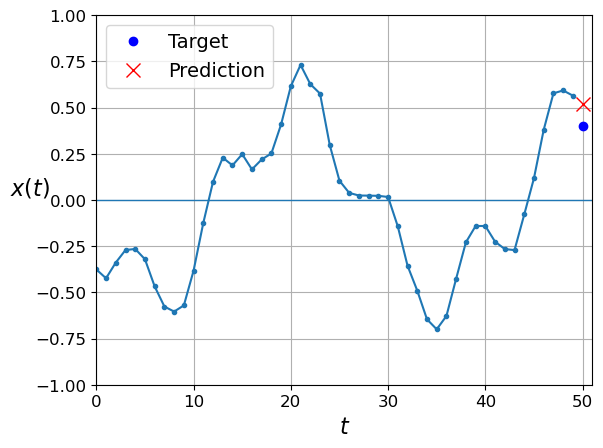

In [13]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

#### Using Deep RNNs

Let's create a three layer RNN network. The first two layers have 20 outputs for each time step. The last layer have a single output for time step, the last output of this layer represents our prediction.

If we set the parameter `return_sequences=False` it will return only the last output, but by using `return_sequences"True` it will return the output for each time step.

By setting to `None` the first dimension of the `input_shape`, we are specufying that the input can have variable length. 

In [14]:
np.random.seed(my_seed)
tf.random.set_seed(my_seed)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 3s 9ms/step - loss: 0.0327 - val_loss: 0.0104
Epoch 2/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0069 - val_loss: 0.0051
Epoch 3/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0049 - val_loss: 0.0043
Epoch 4/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0041 - val_loss: 0.0039
Epoch 5/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0041 - val_loss: 0.0037
Epoch 6/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0037 - val_loss: 0.0035
Epoch 7/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0035 - val_loss: 0.0036
Epoch 8/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0036 - val_loss: 0.0034
Epoch 9/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0034 - val_loss: 0.0033
Epoch 10/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0033 - val_loss: 0.0033

In [15]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 2ms/step - loss: 0.0027


0.0027250393759459257

Now we get a better result than the linear model. Again, let's visualize the prediction of the first time series of our validation set.

63/63 [==============================] - 0s 2ms/step


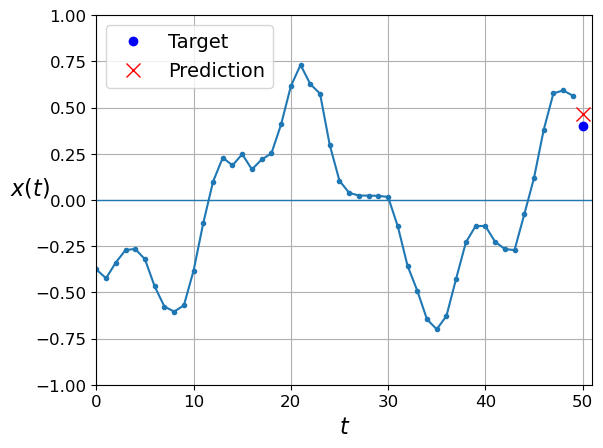

In [16]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

Still the last model was better, the last recurrent layer is not quite useful, we can replace it with a Dense layer with a single neuron and optimize the training time, we just need to get rid of the `return_sequences=True` parameter in the second layer to use the last output.

In [17]:
np.random.seed(my_seed)
tf.random.set_seed(my_seed)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 2s 6ms/step - loss: 0.0087 - val_loss: 0.0038
Epoch 2/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0035 - val_loss: 0.0033
Epoch 3/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 4/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 5/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0031 - val_loss: 0.0032
Epoch 6/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 7/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0029 - val_loss: 0.0032
Epoch 8/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0030 - val_loss: 0.0027
Epoch 9/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0030 - val_loss: 0.0027
Epoch 10/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0029 - val_loss: 0.0027

In [18]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 1ms/step - loss: 0.0025


0.0025248241145163774

As we can see, the result is almost the same as before. Now let's visualize the prediction as we have done it before.

63/63 [==============================] - 0s 1ms/step


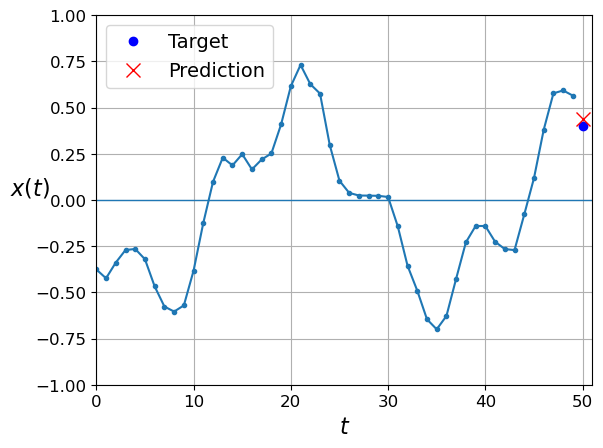

In [19]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

### Forecasting Several Times Ahead

Now, instead of predicting the next value, we will try to predict the next $k$ values using RNNs, but first, we will define a function that will help us to plot the actual series and the estimated one.

In [20]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "bo-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "rx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

Now, The simplest way of estimating the next $k$ values is by predicting only the next value with the model we already have, then use that predicted value as part of our data and then predict a new one; we repeat this $k$ times to obtain the next $k$ predictions.

In [21]:
np.random.seed(my_seed + 1) # a different one to get a different series
series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)
    print(y_pred_one.shape)
    print(X.shape)

Y_pred = X[:, n_steps:]

1/1 [==============================] - 0s 12ms/step
(1, 1, 1)
(1, 51, 1)
1/1 [==============================] - 0s 12ms/step
(1, 1, 1)
(1, 52, 1)
1/1 [==============================] - 0s 12ms/step
(1, 1, 1)
(1, 53, 1)
1/1 [==============================] - 0s 12ms/step
(1, 1, 1)
(1, 54, 1)
1/1 [==============================] - 0s 11ms/step
(1, 1, 1)
(1, 55, 1)
1/1 [==============================] - 0s 11ms/step
(1, 1, 1)
(1, 56, 1)
1/1 [==============================] - 0s 11ms/step
(1, 1, 1)
(1, 57, 1)
1/1 [==============================] - 0s 11ms/step
(1, 1, 1)
(1, 58, 1)
1/1 [==============================] - 0s 11ms/step
(1, 1, 1)
(1, 59, 1)
1/1 [==============================] - 0s 11ms/step
(1, 1, 1)
(1, 60, 1)


In [22]:
Y_pred.shape

(1, 10, 1)

We have our predictions, now let's viualize them and compare them with the actual values.

Saving figure forecast_ahead_plot


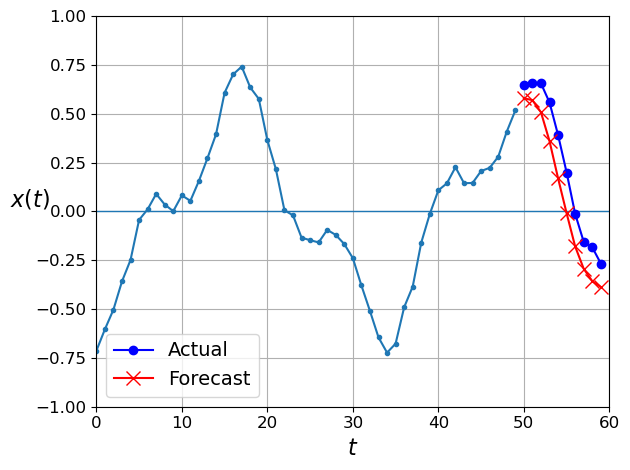

In [23]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
save_fig("forecast_ahead_plot")
plt.show()

#### Using RNNs to predict next $k$ values

Now let's use a RNN that will output the next $k$ values at once, without doing multiple predictions. To do this, we need to modify a little bit our target variable to include $k$ values, and not just one.

In [24]:
np.random.seed(my_seed)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

In [25]:
print(Y_train.shape)
print(Y_valid.shape)
print(Y_test.shape)

(7000, 10)
(2000, 10)
(1000, 10)


The model is almost the same, but the Dense layer contains $k$ neurons, representing the estimated next $k$ values.

In [26]:
np.random.seed(my_seed)
tf.random.set_seed(my_seed)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 2s 6ms/step - loss: 0.0882 - val_loss: 0.0384
Epoch 2/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0325 - val_loss: 0.0267
Epoch 3/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0219 - val_loss: 0.0176
Epoch 4/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0153 - val_loss: 0.0151
Epoch 5/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0135 - val_loss: 0.0112
Epoch 6/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0123 - val_loss: 0.0101
Epoch 7/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0114 - val_loss: 0.0105
Epoch 8/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0108 - val_loss: 0.0093
Epoch 9/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0104 - val_loss: 0.0103
Epoch 10/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0103 - val_loss: 0.0102

Let's create a new series and estimate its next $k$ values, and visualize the result.

In [27]:
np.random.seed(my_seed + 1)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

1/1 [==============================] - 0s 103ms/step


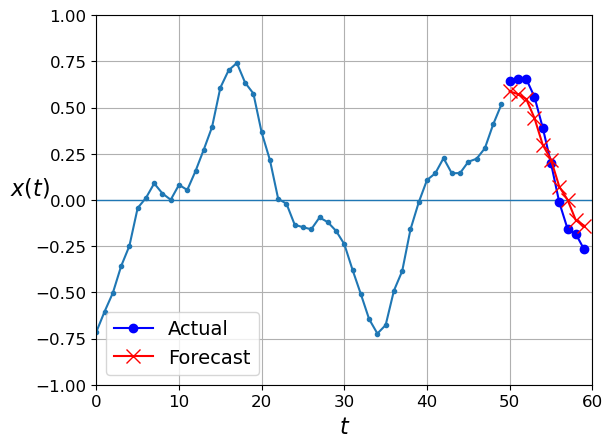

In [28]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

#### Create an RNN that predicts the next $k$ values at each time step

Currently we use only the last output of the last recurrent layer, now we will use the outputs of each time step of this layer, add a dense layer for each one of them by using `keras.layers.TimeDistributed`. But first, we will modify the target variable, to include the next $k$ values for each time step. So now instead of having a shape of $n \times k$, will have a shape of $n \times m \times k$, where $m$ is the number of time steps, which for this example it is 50.

In [29]:
np.random.seed(my_seed)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [30]:
print(X_train.shape)
print(Y_train.shape)
print("------------")

print(X_valid.shape)
print(Y_valid.shape)

(7000, 50, 1)
(7000, 50, 10)
------------
(2000, 50, 1)
(2000, 50, 10)


We will use the last output to measure the performance for our model.

In [31]:
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

In order to include each output of the laste recurrent layer, we need to set `return_sequences=True`, and add a connection to a Dense layer with $k$ neurons to each output by using `keras.layers.TimeDistributed`. The result comes from the last Dense layer.

**In few words, instead of training the model to forecast the next $k$ values only at the very last time step, we can train it to forecast the next $k$ values at each and every time step.**

In [32]:
np.random.seed(my_seed)
tf.random.set_seed(my_seed)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0500 - last_time_step_mse: 0.0390 - val_loss: 0.0385 - val_last_time_step_mse: 0.0249
Epoch 2/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0365 - last_time_step_mse: 0.0240 - val_loss: 0.0366 - val_last_time_step_mse: 0.0248
Epoch 3/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0308 - last_time_step_mse: 0.0185 - val_loss: 0.0290 - val_last_time_step_mse: 0.0176
Epoch 4/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0283 - last_time_step_mse: 0.0162 - val_loss: 0.0261 - val_last_time_step_mse: 0.0140
Epoch 5/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0263 - last_time_step_mse: 0.0144 - val_loss: 0.0247 - val_last_time_step_mse: 0.0122
Epoch 6/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0247 - last_time_step_mse: 0.0121 - val_loss: 0.0250 - val_last_time_step_mse: 0.0123
Epoch 7/20
219/219 [========

Let's create a new time series and forecast the next $k$ values, then we visualize the result.

In [33]:
np.random.seed(my_seed + 1)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)
print(Y_pred.shape)
Y_pred = Y_pred[:, -1][..., np.newaxis]
print(Y_pred.shape)

1/1 [==============================] - 0s 103ms/step
(1, 50, 10)
(1, 10, 1)


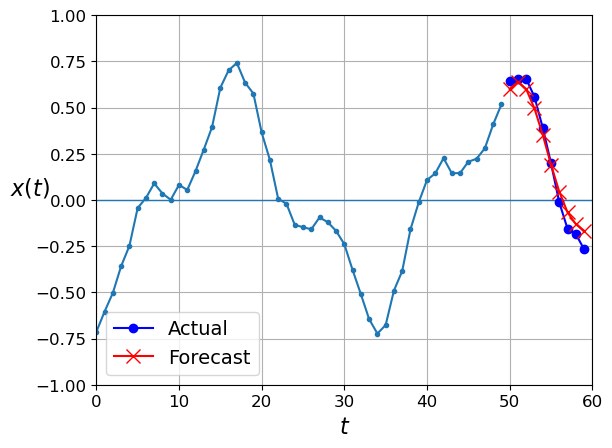

In [34]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

## LSTMs

LSTMs help deal with the problem of limited short memory. Keras allows us to use them in a similar way we have been using the `SimpleRMM`; we only need to use instead `keras.layers.LSTM`. It might not be beneficial for this specific example, but LSTMs are very handy for long sequences.

In [ ]:
np.random.seed(my_seed)
tf.random.set_seed(my_seed)

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20


In [ ]:
model.evaluate(X_valid, Y_valid)

In [ ]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

In [ ]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()